## Setup

In [1]:
import pandas as pd
import numpy as np 
import re
import tqdm
import matplotlib.pyplot as plt
from jupyterthemes import jtplot

jtplot.style()

In [2]:
from transformers import DistilBertModel, DistilBertTokenizer
import torch
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

GENERATE = False

# load raw data
raw_df = pd.read_csv('nuforc_reports.csv')
# remove empty summaries
df = raw_df.dropna(subset='summary')
idx = df.index

if GENERATE:
    embeddings = []
    tokens = df['summary'].dropna().apply(tokenizer.tokenize)
    for t in tqdm.tqdm(tokens):
        input_ids = torch.tensor([tokenizer.convert_tokens_to_ids(t)])
        with torch.no_grad():
            # retrieve embeddings
            last_hidden_states = model(input_ids)[0]
        embedding = last_hidden_states[0][0].numpy()
        embeddings.append(embedding)
    pd.Series(embeddings, index=idx).to_pickle('embeddings.pickle')
    embeddings_arr = np.vstack(embeddings)
else:
    embeddings = pd.read_pickle('embeddings.pickle')
    embeddings_arr = np.vstack(embeddings)
    

In [3]:
#!conda install hdbscan -c conda-forge -y

## Generate low dimensional space for plotting clusters

In [4]:
import umap 
# 2d visualisation
umap_embeddings_2d = umap.UMAP(n_neighbors=15, 
                            n_components=2, 
                            metric='cosine').fit_transform(embeddings_arr)


In [5]:
# plots
umap_embeddings_10d = umap.UMAP(n_neighbors=15, 
                            n_components=10, 
                            metric='cosine').fit_transform(embeddings_arr)

In [6]:
import hdbscan
def train_clusterer(input_arr):
    clusterer = hdbscan.HDBSCAN(min_cluster_size=500,
                                min_samples=500,
                                cluster_selection_epsilon=0.5,
                                core_dist_n_jobs = 4,
                                metric='euclidean')
    cluster_labels = clusterer.fit_predict(input_arr)
    return clusterer, cluster_labels

model, clusters = train_clusterer(umap_embeddings_10d)

In [7]:
# rename -1 cluster 
noise =  max(clusters)+1
clusters = np.where(clusters != -1, clusters, noise)

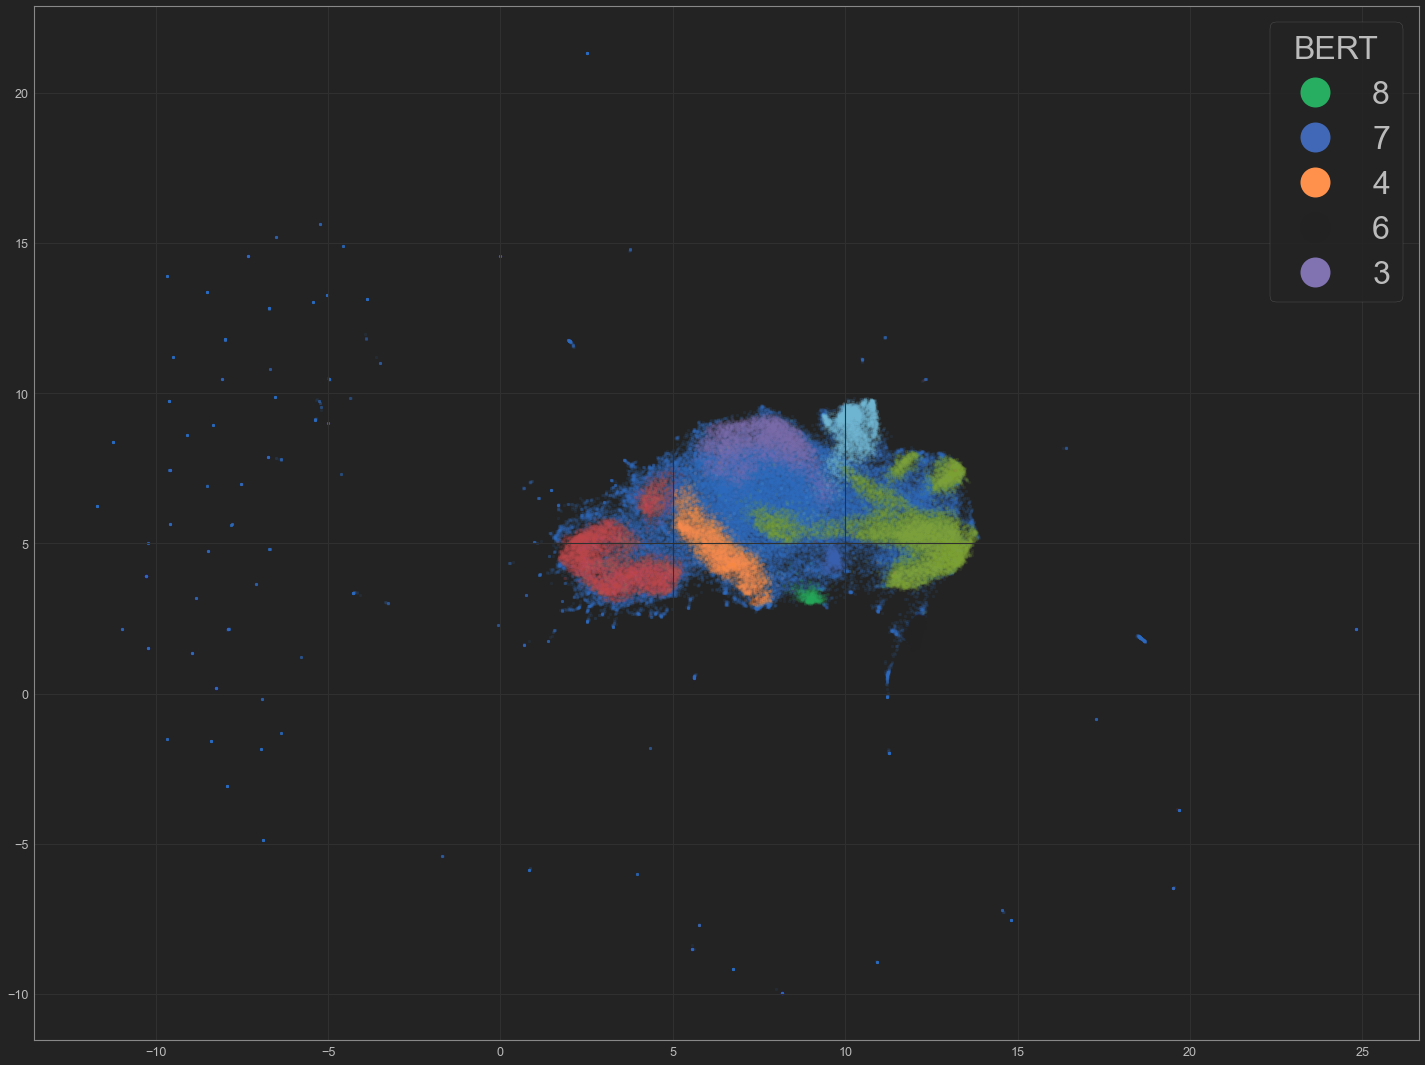

In [8]:
fig, axes = plt.subplots(1,1, figsize=(20, 15))
labels = clusters
unique_labels = set(labels)
cluster_sizes = {label: sum(labels == label) for label in set(labels)}
# get 5 largest
top_n = 5
sorted_clusters = sorted(cluster_sizes, key=cluster_sizes.get, reverse=True)
legend_elements = []
for i, label in enumerate(sorted_clusters):            
    axes.scatter(umap_embeddings_2d[labels == label , 0], umap_embeddings_2d[labels == label , 1],
                           label=label, alpha=0.1, s=10)
    if i < top_n:
        legend_elements.append(plt.Line2D([0], [0], linewidth=0.0001, marker='o', color='w', 
                                              label=label, markerfacecolor='C'+str(label), markersize=30))
axes.legend(handles=legend_elements, title='BERT', title_fontsize='32', fontsize=32, loc='upper right')

jtplot.style(grid=False)
plt.tight_layout()
plt.show()

In [12]:
len(set(clusters))

9

In [16]:
# plots
umap_embeddings_2d2 = umap.UMAP(n_neighbors=150, 
                            n_components=2, 
                            metric='cosine').fit_transform(embeddings_arr)

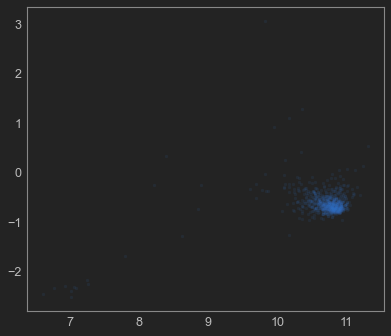

In [17]:
plt.scatter(umap_embeddings_2d2[labels == label , 0], umap_embeddings_2d2[labels == label , 1],
                           label=label, alpha=0.1, s=10)

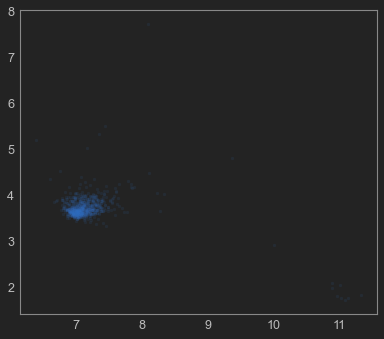

In [18]:
# plots
umap_embeddings_2d3 = umap.UMAP(n_neighbors=50, 
                            n_components=2, 
                            metric='cosine').fit_transform(embeddings_arr)

plt.scatter(umap_embeddings_2d3[labels == label , 0], umap_embeddings_2d3[labels == label , 1],
                           label=label, alpha=0.1, s=10)

In [19]:
model, clusters = train_clusterer(umap.UMAP(n_neighbors=20, 
                            n_components=20, 
                            metric='cosine').fit_transform(embeddings_arr))

In [20]:
# rename -1 cluster 
noise =  max(clusters)+1
clusters = np.where(clusters != -1, clusters, noise)

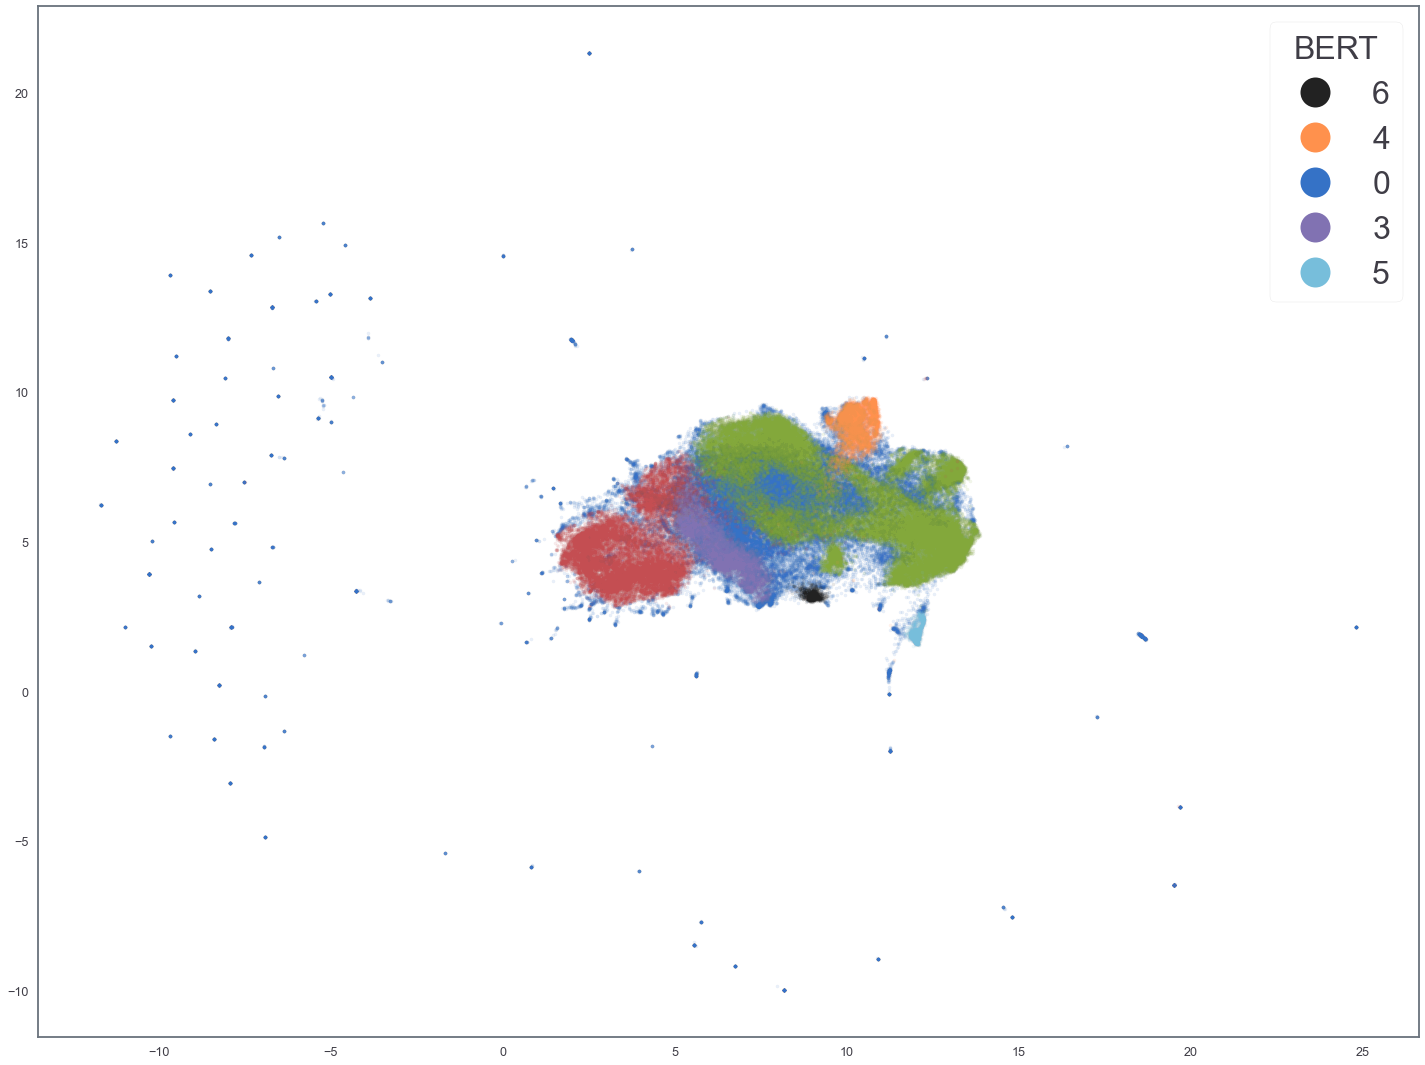

In [28]:
jtplot.style('grade3', context='talk', grid=False)
fig, axes = plt.subplots(1,1, figsize=(20, 15))
labels = clusters
unique_labels = set(labels)
cluster_sizes = {label: sum(labels == label) for label in set(labels)}
# get 5 largest
top_n = 5
sorted_clusters = sorted(cluster_sizes, key=cluster_sizes.get, reverse=True)
legend_elements = []
for i, label in enumerate(sorted_clusters):            
    axes.scatter(umap_embeddings_2d[labels == label , 0], umap_embeddings_2d[labels == label , 1],
                           label=label, alpha=0.1, s=10)
    if i < top_n:
        legend_elements.append(plt.Line2D([0], [0], linewidth=0.0001, marker='o', color='w', 
                                              label=label, markerfacecolor='C'+str(label), markersize=30))
axes.legend(handles=legend_elements, title='BERT', title_fontsize='32', fontsize=32, loc='upper right')

jtplot.style(grid=False)
plt.tight_layout()
plt.show()

In [22]:
df['clusters'] = clusters

C:\Users\Connor\AppData\Local\Temp\ipykernel_3908\1600189321.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clusters'] = clusters


In [24]:
for g, d in df.groupby('clusters'):
    print(f'Cluster {g} sample: ')
    for i in range(0, 10):
        print(d.summary.iloc[i])

Cluster 0 sample: 
Steady flashing object with three lights hovered  in sky
1969 olive branch Mississippi large round light no sound moved away at tremdious speed.
Large Chevron Shaped Object  Slowly Passing Overhead
MADAR logged anomaly #15.
Flying Orange Spider/Octopus looking creature spotted in New Jersey 1978
Cigar shaped object
Oval shaped dark metallic red object moving at mach speed.
mother ship
Circular upside down bowl shape with lights
Christmas type UFO
Cluster 1 sample: 
((HOAX??))  On Google earth, found underwater base with three large doors and a Tictac shaped UFO.  ((anonymous report))
((HOAX??))  Me and my friend were out walking the hunting ground we herd something up in the sky
((HOAX??))The TV was changing to the same character's the radio  stations I had a scratch  on my forehead and a circle  on my finger
((Hoax?))  Dark behind the cloud
((NUFORC Note:  HOAX??  PD))  Very light white ufos showing out of no where—& Blue Alien
((HOAX??))  Ufo craft caught in Phoeni

,0,1
0,9.063759,12.211605
1,5.712997,1.785878
2,0.918347,3.060861
3,0.596972,0.015657
4,1.074072,1.635830
...,...,...
141184,2.831868,1.680005
141185,20.046329,3.986066
141186,0.752466,0.044402
141187,1.904406,0.599381


In [41]:
from scipy import stats
 
z_scores = np.abs(stats.zscore(
    np.sqrt(abs(umap_embeddings_2d[:, 0] * umap_embeddings_2d[:, 1]))
))
outliers = np.where(z_scores > 3)
outliers

(array([    36,    259,    374,   1163,   1292,   1317,   1357,   1359,
          2766,   2779,   3026,   3524,   4545,   4992,   5000,   5114,
          5440,   6240,   6409,   6410,   6414,   6749,   6769,   7055,
          7329,   7551,  11948,  13275,  15497,  18820,  22563,  23221,
         25677,  27028,  29437,  30769,  33622,  33651,  34212,  35196,
         37876,  42894,  43492,  45951,  46362,  52880,  56758,  57227,
         63319,  73631,  76838,  79666,  91042,  91661,  92743,  96307,
         96513, 103768, 118046, 118190, 118197, 118385, 121232, 121434,
        122164, 122293, 122295, 122348, 122366, 122372, 122381, 122403,
        122522, 122526, 122605, 122606, 122702, 122712, 122968, 123273,
        123275, 123277, 123282, 123394, 123530, 123727, 123957, 124033,
        124299, 124301, 124592, 124816, 125230, 125365, 125683, 125887,
        126170, 126534, 126577, 126944, 127514, 127613, 127856, 128470,
        128543, 128814, 128959, 129012, 129191, 129199, 129358, 

In [45]:
for idx, row in df.loc[outliers[0], :].iterrows():
    print(row.summary)

((NUFORC Note:  Source of report does not include detailed information.  PD))
MADAR Node 135
((NUFORC Note:  Source of report does not include detailed information.  PD))
[ ] Sitting in McDonald's parking lot; Albany NY. October 26, 2019. Time : 9:30am - 10am.

Unidentified flying object Heading Easterl
Two tiny lights become one, then fade away slowly.
300 yards in front of us and was a black equilateral triangle shaped object.
There were bright orange, orb looking objects moving through the sky that looked very odd and out of the ordinary.
Bright stars and started dancing and moves sporadically with colored lights.
Bright lights, slowly moving at mid to top of trees
Bright white light crossing from Southeast to Northwest fast and Bright/large.... faster than airforce jets that are normally crossing
Red colored orb sitting high in sky in one spot, hovering. Then raised straight up, fast, to a very high altitude in the sky and turned
MADAR Node 100
The object like a black bowling ball 

In [49]:
df.index.isin(outliers).astype(int)

array([0, 0, 0, ..., 0, 0, 0])

2


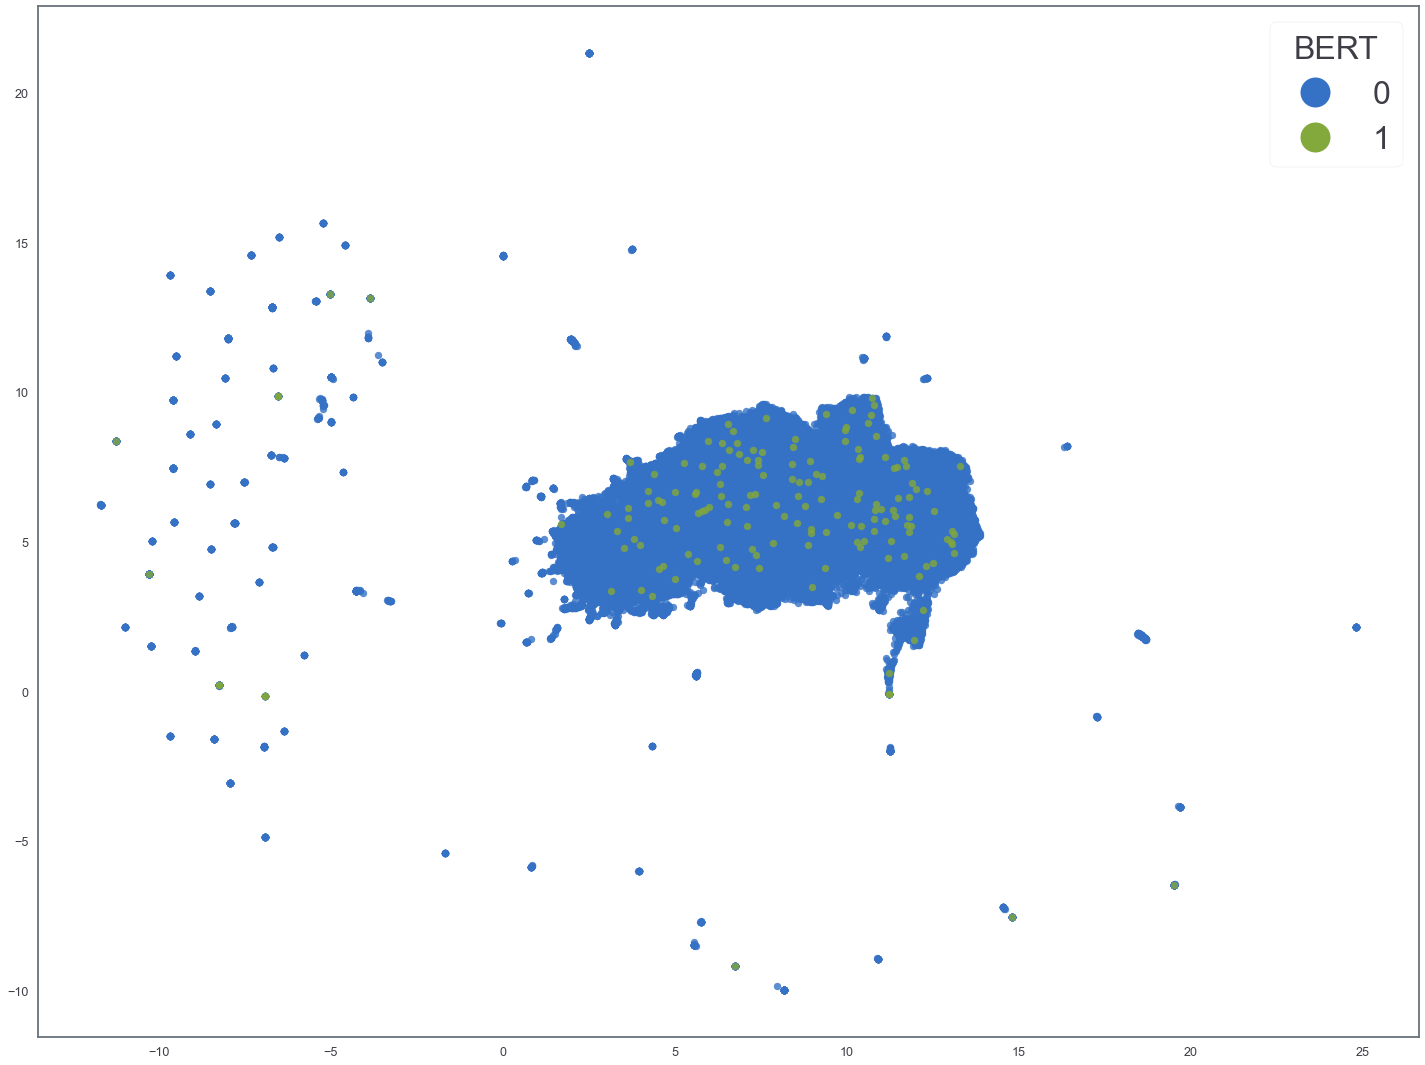

In [53]:
jtplot.style('grade3', context='talk', grid=False)
fig, axes = plt.subplots(1,1, figsize=(20, 15))
labels = df.index.isin(outliers[0]).astype(int)
unique_labels = set(labels)
cluster_sizes = {label: sum(labels == label) for label in set(labels)}
# get 5 largest
print(len(cluster_sizes))
top_n = 2
sorted_clusters = sorted(cluster_sizes, key=cluster_sizes.get, reverse=True)
legend_elements = []
for i, label in enumerate(sorted_clusters):          
    
    axes.scatter(umap_embeddings_2d[labels == label , 0], umap_embeddings_2d[labels == label , 1],
                           label=label, alpha=0.8, s=50)
    if i < top_n:
        legend_elements.append(plt.Line2D([0], [0], linewidth=0.0001, marker='o', color='w', 
                                              label=label, markerfacecolor='C'+str(label), markersize=30))
axes.legend(handles=legend_elements, title='BERT', title_fontsize='32', fontsize=32, loc='upper right')

jtplot.style(grid=False)
plt.tight_layout()
plt.show()

In [67]:
umap_embeddings_2d.T[0]

array([19.509123,  4.732367,  9.527017, ..., 11.19783 , 12.34977 ,
        7.94101 ], dtype=float32)

In [74]:
import pdb
outliers_xy = []

for i in 0, 1:
    arr_1d = umap_embeddings_2d.T[i]
    q1 = np.percentile(arr_1d, 25)
    q3 = np.percentile(arr_1d, 75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    outliers = np.where((arr_1d > upper_bound) | (arr_1d < lower_bound))
    outliers_xy.append(outliers)

In [84]:
outlier_idx = pd.Index(outliers_xy[0][0]).append(pd.Index(outliers_xy[1][0]))

In [85]:
df.loc[outlier_idx]

KeyError: '[1535, 130090, 131147, 1653, 36870, 133651] not in index'

In [61]:
outliers[0].shape

(2952,)

In [62]:
umap_embeddings_2d

array([[19.509123 , -6.4685936],
       [ 4.732367 ,  3.9571326],
       [ 9.527017 ,  8.803872 ],
       ...,
       [11.19783  ,  5.698609 ],
       [12.34977  ,  5.14363  ],
       [ 7.94101  ,  8.188594 ]], dtype=float32)

## text 

In [93]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

GENERATE_TEXT_EMBEDDINGS = True
if GENERATE_TEXT_EMBEDDINGS:
    text_embs = []
    tokens = df['text'].dropna().sample(10, random_state=42).apply(tokenizer.tokenize)
    idx =  df['text'].dropna().sample(10, random_state=42).apply(tokenizer.tokenize)
    for t in tqdm.tqdm(tokens):
        input_ids = torch.tensor([tokenizer.convert_tokens_to_ids(t)])
        with torch.no_grad():
            # retrieve text_embs
            last_hidden_states = model(input_ids)[0]
        embedding = last_hidden_states[0][0].numpy()
        text_embs.append(embedding)
    pd.Series(text_embs, index=idx).to_pickle('text_embs.pickle')
    text_embs_arr = np.vstack(text_embs)
else:
    text_embs = pd.read_pickle('text_embs.pickle')
    text_embs_arr = np.vstack(text_embs)
    

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.83it/s]


In [95]:
text_embs_arr

array([[-0.04497476,  0.05608898,  0.13747923, ..., -0.14267698,
         0.18916598, -0.05108851],
       [-0.31705686,  0.00969136, -0.17021264, ..., -0.41834795,
         0.24728328, -0.3475908 ],
       [-0.02026522,  0.15436576,  0.22879131, ..., -0.1593361 ,
         0.24660996,  0.17639334],
       ...,
       [-0.22829309, -0.04412128,  0.38367832, ..., -0.18917458,
         0.19874984,  0.08337875],
       [-0.05975959,  0.14231846,  0.04011612, ..., -0.13239512,
         0.3495791 ,  0.28871447],
       [-0.02820934,  0.3126555 ,  0.38197982, ..., -0.46380892,
         0.2366665 , -0.36712265]], dtype=float32)